# Problem Statement

Given is weighted locality routes graph with :
1. Vertices as Checkpoints. 
2. Edges as the routes.
3. Edge Weights as the Travel Time.(Randomly alloted to each edge)
 
Moreover, each route is randomly given a status as follows:
<table>
<tr>
<td>Status</td>
<td>Edge Colour</td>
<td>Delay in Travel Time</td>
</tr>
<tr>
<td>Congestion</td>
<td>Red</td>
<td>4</td>
</tr>
<tr>
<td>Construction Work</td>
<td>Blue</td>
<td>8</td>
</tr>
<tr>
<td>Accident</td>
<td>Orange</td>
<td>6</td>
</tr>
<tr>
<td>No issue</td>
<td>Green</td>
<td>0</td>
</tr>
</table>

The Utility agent finds all paths between a source and destination using Depth First Search(DFS) and gives the most preferred route with reference to the Estimated Time of Arrival(ETA). Less the ETA more the preference.

# Importing the required modules

In [232]:
# Modules used for graph visualizations.
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Modules used for data handling.
import pandas as pd
import random as r

# Modules used for visualization of tables.
from tabulate import tabulate

# Reading the Adjacency Matrix of the Routes Graph

In [233]:
f = open(r"../data/routeGraph.txt","r")

# Conversion of Adjacency Matrix into a DataFrame

In [234]:
def separate(x):
    if x != '':
     return list(map(int,x.split(",")))

In [235]:
adjacencyMatrix = f.read().split("\n")
adjacencyMatrix = list(map(separate,adjacencyMatrix))

In [236]:
adjacencyMatrix = pd.DataFrame(adjacencyMatrix,index=range(1,16),columns=range(1,16))
adjacencyMatrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0
5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
8,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
9,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
10,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1


# Finding all paths between a source and destination

In [237]:
allpaths = []
def findPaths(graph,source, destination,visited,path):
        visited.append(source)
        path.append(source)
        if source == destination:
            allpaths.append(path.copy())
        else:
            if source in graph:
             for i in graph[source]:
                if i not in visited:
                    findPaths(graph,i, destination, visited, path)
        x = path.pop()
        visited.remove(source)

# Agent Programming

## Environment Code

In [239]:
class Environment:
    def __init__(self) :
        self.color = {"Congestion":"r","Construction work":"b","Accident":"orange","No issue":"g"}
        self.env = dict()
        self.routeStats = pd.DataFrame(columns=['Vertex 1','Vertex 2','Travel Time','Status'])
        self.status = ["Congestion","Construction work","Accident","No issue"]
    def createEnv(self):
        for j in adjacencyMatrix.index:
            #print("For",j)
            for i in adjacencyMatrix.columns:
                if adjacencyMatrix.at[j,i] == 1:
                 if  j in self.env:
                    #print(i)
                    self.env[j].append(i)
                    #print()
                 else:
                    self.env[j] = [i]
    def showEnv(self):
        g = nx.Graph()
        for i in self.env:
            for j in self.env[i]:
               if (i,j) not in g.edges() or (j,i) not in g.edges():  
                g.add_edge(i,j)
                g[i][j]['weight'] = r.randint(a=1,b=10)
                s = r.choice(self.status)
                self.routeStats = self.routeStats.append({'Vertex 1':i,'Vertex 2':j,'Travel Time':g[i][j]['weight'],'Status':s},ignore_index=True)
                g[i][j]['color'] = self.color[s]
        return g
    def getRoutes(self):
        return self.routeStats

## Agent Code

In [240]:
class Agent:
    def __init__(self) :
        self.delay = {"Congestion":4,"Construction work":8,"Accident":6,"No issue":0}
        self.paths = None
        self.etas = []
        self.routes = None
    def computeETA(self,path,routestats):
        eta = 0
        for i in range(1,len(path)):
            x = routestats[["Travel Time","Status"]][(routestats["Vertex 1"] == path[i-1]) & (routestats["Vertex 2"] == path[i]) | (routestats["Vertex 1"] == path[i]) & (routestats["Vertex 2"] == path[i-1])].reset_index()
            eta += x["Travel Time"][0] + self.delay[x["Status"][0]]
        self.etas.append(eta)
    def prefer(self,routestats):
        for i in allpaths:
            self.computeETA(i,routestats)
        self.routes = pd.DataFrame({'Route':list(map(str,allpaths)),'ETA':self.etas})
        self.routes = self.routes.sort_values(by=["ETA"],ascending=True).reset_index()
    def getRoutes(self,env,routestats):
        findPaths(env,1,15,[],[])
        self.paths = allpaths.copy()
        self.prefer(routestats)

# Driver's Code

## Preparation of the Environment

In [241]:
e = Environment()
e.createEnv()
g = e.showEnv()
pos = nx.spring_layout(g)

## Status of the Routes

In [242]:
e.getRoutes()[["Travel Time","Status"]]

,Travel Time,Status
0,3,Congestion
1,4,Construction work
2,6,Accident
3,5,Construction work
4,4,No issue
5,7,No issue
6,4,Congestion
7,1,Accident
8,9,No issue
9,10,Construction work


## Visualising the Environment

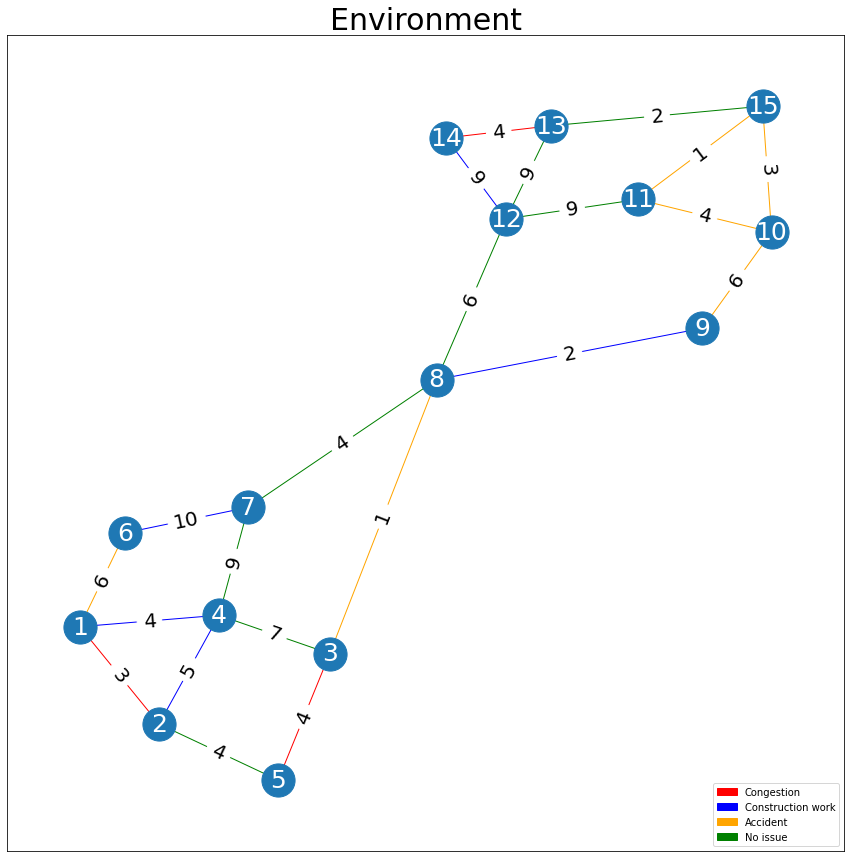

In [243]:

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(g, pos=pos,node_size=1100)
nx.draw_networkx_edges(g, pos=pos,edge_color=nx.get_edge_attributes(g,'color').values())
nx.draw_networkx_labels(g, pos, font_size=25,font_color='w')
nx.draw_networkx_edge_labels(g,pos,edge_labels=nx.get_edge_attributes(g,'weight'),font_size=20)
plt.title("Environment",font={"size":30})
red_patch = mpatches.Patch(color='red', label='Congestion')
blue_patch = mpatches.Patch(color='blue', label='Construction work')
orange_patch = mpatches.Patch(color='orange', label='Accident')
green_patch = mpatches.Patch(color='green', label='No issue')
plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch],loc='lower right')
plt.show()

## Creating the Agent

In [244]:
a = Agent()
a.getRoutes(e.env,e.routeStats)

In [245]:
print(tabulate(a.routes.drop(['index'],axis=True),headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════════════════════════════════════════════╤═══════╕
│    │ Route                                               │   ETA │
╞════╪═════════════════════════════════════════════════════╪═══════╡
│  0 │ [1, 4, 7, 8, 12, 13, 15]                            │    42 │
├────┼─────────────────────────────────────────────────────┼───────┤
│  1 │ [1, 4, 3, 8, 12, 13, 15]                            │    43 │
├────┼─────────────────────────────────────────────────────┼───────┤
│  2 │ [1, 2, 5, 3, 8, 12, 13, 15]                         │    43 │
├────┼─────────────────────────────────────────────────────┼───────┤
│  3 │ [1, 4, 7, 8, 12, 11, 15]                            │    47 │
├────┼─────────────────────────────────────────────────────┼───────┤
│  4 │ [1, 2, 5, 3, 8, 12, 11, 15]                         │    48 │
├────┼─────────────────────────────────────────────────────┼───────┤
│  5 │ [1, 4, 3, 8, 12, 11, 15]                            │    48 │
├────┼────────────────────────────

Utility Based Agent will choose the route with least ETA (i.e. [1, 4, 7, 8, 12, 13, 15]) while a Goal Based Agent would have just provided a route randomly from all the routes between source and destination.